In [16]:
# general 
import pandas as pd 
import numpy as np 
import pickle

import pyarrow as pa
import pyarrow.parquet as pq

# stats
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10, 5)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.preprocessing import StandardScaler

# arima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.utils import plot_acf, plot_pacf, autocorr_plot

# from common files
from common import timeseries_evaluation_metrics_func, adfuller_test, grangers_causation_matrix

# silence warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load all dataframes
cgm_df = pd.read_parquet("Parquet Files/cgm_df.parquet.gzip")
final_df = pd.read_parquet("Parquet Files/final_df.parquet.gzip")
full_day_min_cgm = pd.read_parquet("Parquet Files/full_day_min_cgm.parquet.gzip")

## ARIMA

- Pure ARIMA for glucose
- ARIMAX with HRV exogenous variables
- VARMA with HRV exogenous variables

For the remainder of the methods, only a simple time series split will be performed, so as to lessen computation time.

In [4]:
# split data into train, validation and test
# final day of test set for validation
TEST_SIZE = 0.125

# split using pmdarima's TTS to not shuffle data
train, test = train_test_split(final_df, test_size=TEST_SIZE)

print(f"Shape of train: {train.shape},\
 shape of test: {test.shape}")

Shape of train: (1098, 24), shape of test: (157, 24)


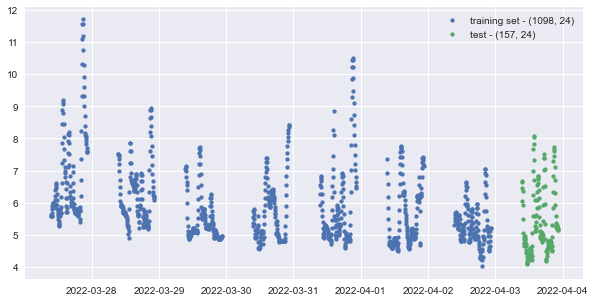

In [5]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y=train['glucose'], x=train.index,
           label=f"training set - {train.shape}", s=15)
ax.scatter(y=test['glucose'], x=test.index,
           label=f"test - {test.shape}", s=15)
ax.legend()

In [6]:
# perform augmented dickey fuller test for unit root
adfuller_test(train['glucose'], name="Glucose")

    Augmented Dickey-Fuller Test on "Glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9497
 No. Lags Chosen       = 8
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



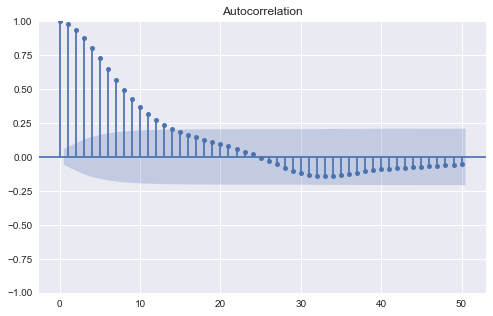

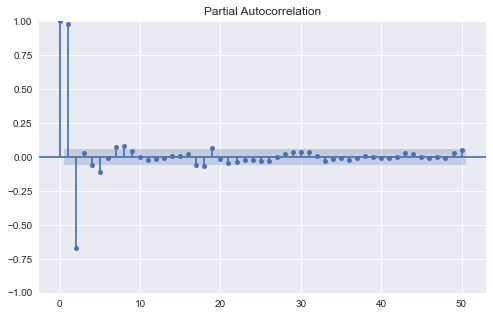

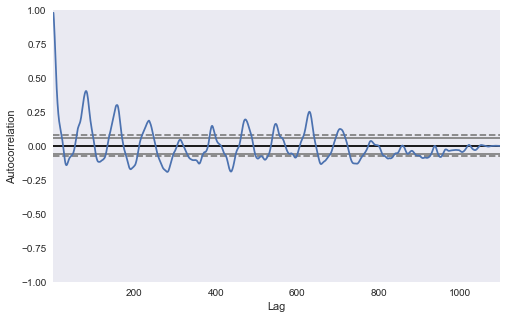

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
acf = plot_acf(train['glucose'], ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(8, 5))
pacf = plot_pacf(train['glucose'], ax=ax, alpha=0.05, lags=50)

fig, ax = plt.subplots(figsize=(8, 5))
autocorr_plot(train['glucose'])

As seen, autocorrelation up til 10, and partial autocorrelation up to 3. Obvious signs of seasonality in glucose readings.

# ARIMA

In [8]:
model = pm.auto_arima(train['glucose'],
                      trace=True,
                      max_p=5, max_q=20, max_order=25,
                      stepwise=True,
                      seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-629.649, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.448, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-632.527, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-496.392, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.445, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-632.834, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-630.875, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-630.846, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-632.837, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-630.878, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-605.210, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-634.836, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-498.390, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-634.526, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]            

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1098
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 320.418
Date:                Mon, 04 Apr 2022   AIC                           -634.836
Time:                        23:15:00   BIC                           -619.835
Sample:                             0   HQIC                          -629.161
                               - 1098                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5810      0.025     23.636      0.000       0.533       0.629
ma.L1          0.0730      0.024      3.023      0.003       0.026       0.120
sigma2         0.0326      0.000    119.997      0.000       0.032       0.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            196782.56
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
test_pred, confint = model.predict(n_periods=len(test), return_conf_int=True)
arima_rmse = timeseries_evaluation_metrics_func(test['glucose'], test_pred)
print(f"Mean RMSE for ARIMA forecast: {arima_rmse['rmse']}.")

Mean RMSE for ARIMA forecast: 1.0296245735265677.


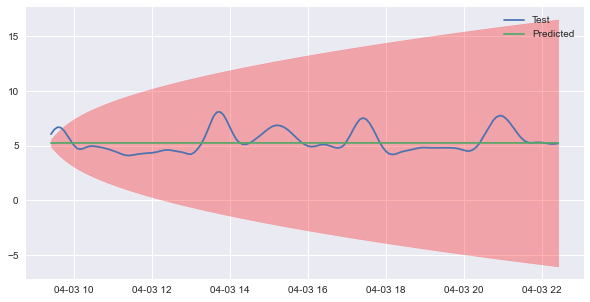

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test['glucose'].index, test['glucose'], label='Test')
ax.plot(test['glucose'].index, test_pred, label='Predicted')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

# ARIMAX 
ARIMA + exogenous variables from HRV time domain/frequence domain features

final_df information:
- 5 minute data from 0950 to 2150 hours from day 2 to day 6 (12 hours per day)
- 24 columns, including the CGM values for the 9 hours
- 868 rows

Stationarity checks with ADFuller

In [12]:
# run augmented dickey-fuller test on all columns to detect stationarity
def adf_harness(data):
    for colname, colvalues in data.iteritems():
        adfuller_test(colvalues, name=colname)
         
adf_harness(final_df)

    Augmented Dickey-Fuller Test on "glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6327
 No. Lags Chosen       = 7
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "mean_nni" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5315
 No. Lags Chosen       = 15
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "sdnn" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [13]:
fig = px.scatter(final_df)
fig.show()

In [14]:
# final day of test set for validation
TEST_SIZE_PERCENT = 0.125

# split using pmdarima's TTS to not shuffle data
y_train, y_test = train_test_split(final_df, test_size=TEST_SIZE_PERCENT)
print(f"Shape of train: {y_train.shape}, shape of test: {y_test.shape}")

Shape of train: (1098, 24), shape of test: (157, 24)


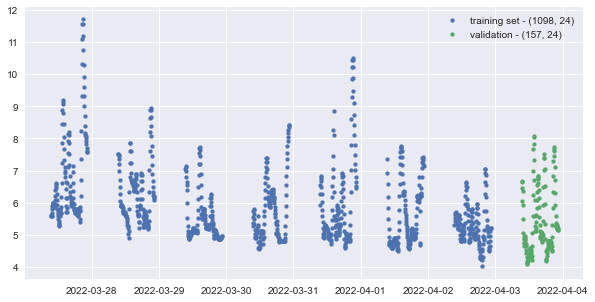

In [18]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y=y_train['glucose'], x=y_train.index, label=f"training set - {y_train.shape}", s=15)
ax.scatter(y=y_test['glucose'], x=y_test.index, label=f"validation - {y_test.shape}", s=15)
ax.legend()

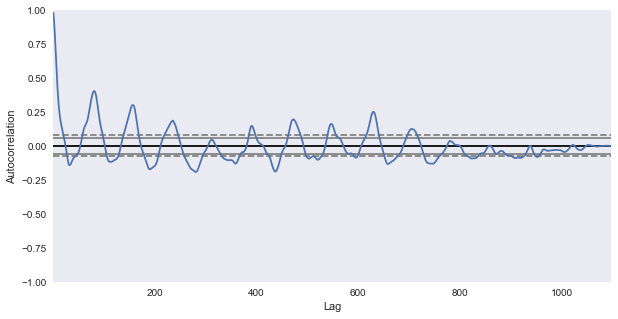

In [52]:
from statsmodels.tsa.stattools import pacf, acf

def create_corr_plot(series, lags=30, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05, nlags=lags) if plot_pacf\
        else acf(series.dropna(), alpha=0.05, nlags=lags)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=5)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,(0.7*lags)])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()
    
create_corr_plot(final_df['glucose'], lags=200)
create_corr_plot(final_df['glucose'], plot_pacf=True)

fig, ax = plt.subplots(figsize=(10, 5))
autocorr_plot(y_train['glucose'])

Possible params for p term: 12, q term: 3.

In [85]:
# passing in HRV params as exogenous variables
model = pm.auto_arima(y=y_train['glucose'],
                      x=y_train.drop('glucose', axis=1), maxiter=10,
                      seasonal=True, error_action='ignore',
                      suppress_warnings=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=-629.474, Time=6.53 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=-89.448, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-634.290, Time=2.53 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-503.336, Time=3.48 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=-91.445, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=-632.527, Time=0.21 sec
 ARIMA(1,1,0)(2,0,0)[30] intercept   : AIC=-632.687, Time=8.98 sec
 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=-632.683, Time=3.56 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=-634.147, Time=3.07 sec
 ARIMA(1,1,0)(2,0,1)[30] intercept   : AIC=-630.804, Time=9.72 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=-109.095, Time=2.51 sec
 ARIMA(2,1,0)(1,0,0)[30] intercept   : AIC=-634.471, Time=12.05 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=-632.834, Time=0.26 sec
 ARIMA(2,1,0)(2,0,0)[30] intercept   : AIC=-632.766, Time=10.68 sec
 ARIMA(2,1,0)(1,0,1

In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1098
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 30)   Log Likelihood                 322.242
Date:                             Tue, 05 Apr 2022   AIC                           -636.484
Time:                                     00:25:06   BIC                           -616.483
Sample:                                          0   HQIC                          -628.916
                                            - 1098                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5770      0.025     23.224      0.000       0.528       0.626
ma.L1          0.0715      0.024      2.935      0.003       0.024       0.119
ar.S.L30      -0.0576      0.054     -1.074      0.283      -0.163       0.048
sigma2         0.0325      0.000    119.589      0.000       0.032       0.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            196440.34
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
test_pred, confint = model.predict(n_periods=len(y_test), return_conf_int=True)
sarimax_rmse = timeseries_evaluation_metrics_func(y_test['glucose'], test_pred)
print(f"Mean RMSE for ARIMA forecast: {sarimax_rmse['rmse']}.")

Mean RMSE for ARIMA forecast: 1.038001897021987.


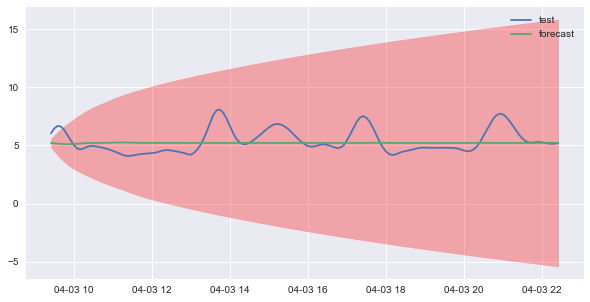

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test['glucose'], label='test')
ax.plot(y_test.index, test_pred, label='forecast')
ax.fill_between(y_test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

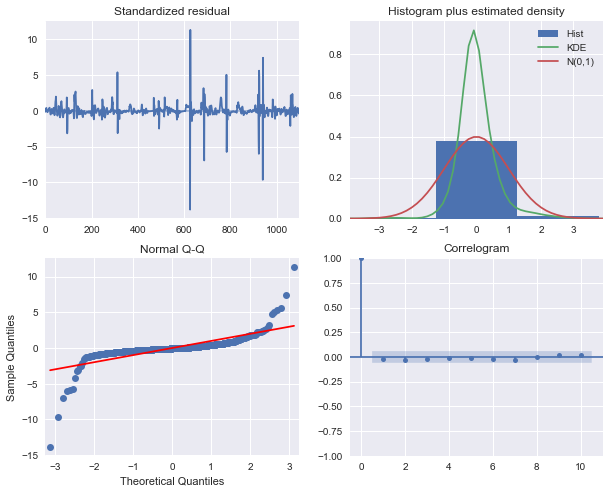

In [76]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

# VARMAX
Since data is multivariate, a forecast attempt can be made with each column as a vector, modelling each column as lagged regressors of the other features + t-lag time series. Focusing only on 'glucose'.

Granger Casuality Test

Refer to:
>https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series

Granger casuality testing only applies to stationary intervals.

- Null hypothesis: HRV feature (x) does not explain variation in (y) glucose.
- Alternative hypothesis: HRV feature (x) has an effect on glucose with a 95% confidence interval that a change in x causes a response in 'glucose' (y)

In [22]:
matrix = grangers_causation_matrix(y_train, variables=y_train.columns)
matrix

,glucose_x,mean_nni_x,sdnn_x,sdsd_x,nni_50_x,pnni_50_x,nni_20_x,pnni_20_x,rmssd_x,median_nni_x,...,max_hr_x,min_hr_x,std_hr_x,lf_x,hf_x,lf_hf_ratio_x,lfnu_x,hfnu_x,total_power_x,vlf_x
glucose_y,1.0000,0.0152,0.0011,0.0019,0.0027,0.0035,0.0455,0.0180,0.0019,0.0186,...,0.0080,0.0033,0.0605,0.0982,0.0188,0.5551,0.0394,0.0394,0.0085,0.0096
mean_nni_y,0.6028,1.0000,0.0000,0.0296,0.3405,0.3353,0.0275,0.1330,0.0297,0.0206,...,0.2001,0.0000,0.0033,0.0036,0.0541,0.0022,0.0007,0.0007,0.0090,0.0154
sdnn_y,0.0228,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0001,0.0000,0.1590,0.0425,0.0425,0.0016,0.1881
sdsd_y,0.4099,0.0000,0.3913,1.0000,0.0000,0.0000,0.2629,0.0004,0.0128,0.0000,...,0.0086,0.0279,0.0028,0.0174,0.0000,0.6030,0.1415,0.1415,0.4296,0.5165
nni_50_y,0.4099,0.0003,0.4710,0.2007,1.0000,0.0001,0.4943,0.0228,0.2003,0.0003,...,0.0034,0.0433,0.0095,0.0282,0.0003,0.3342,0.1206,0.1206,0.3599,0.3495
pnni_50_y,0.3622,0.0028,0.1018,0.1309,0.0421,1.0000,0.6744,0.2086,0.1310,0.0086,...,0.0446,0.0095,0.5505,0.0138,0.0077,0.1023,0.0472,0.0472,0.4871,0.4718
nni_20_y,0.5843,0.0000,0.2891,0.0435,0.1317,0.0184,1.0000,0.0024,0.0434,0.0002,...,0.0000,0.0000,0.0003,0.1015,0.2625,0.0385,0.0086,0.0086,0.0926,0.0554
pnni_20_y,0.5256,0.0045,0.0167,0.1847,0.5891,0.4821,0.2620,1.0000,0.1849,0.0498,...,0.0247,0.0000,0.2596,0.0905,0.1722,0.0050,0.0039,0.0039,0.0978,0.0353
rmssd_y,0.4092,0.0000,0.3908,0.0132,0.0000,0.0000,0.2636,0.0004,1.0000,0.0000,...,0.0086,0.0281,0.0028,0.0174,0.0000,0.6025,0.1411,0.1411,0.4293,0.5167
median_nni_y,0.7066,0.0000,0.0023,0.0139,0.1285,0.1637,0.0039,0.0008,0.0139,1.0000,...,0.0075,0.0000,0.2471,0.0088,0.0354,0.0081,0.0011,0.0011,0.0542,0.0781


*_x are the independent variables, *_y are dependent variables. First row is of interest (only glucose_y)
- For most attributes (e.g. mean_nni_x, sdnn_x, etc) the null hypothesis of 0.05 is the threshold for which the x variable granger causes y
- Most variables seem to granger cause *_y.

In [23]:
rel_metrics = matrix.iloc[0]
GRANGER_THRESHOLD = 0.05

def metric_select(srs, threshold=GRANGER_THRESHOLD):
    # drop metrics that fail 0.05 granger null hypothesis threshold
    s = srs.copy()
    for idx, metric in s.iteritems():
        if metric >= GRANGER_THRESHOLD:
            s.drop(idx, inplace=True)
    return s

def extract_metrics(srs):
    keys = list(srs.keys())
    return [i[:-2] for i in keys]

feat = extract_metrics(metric_select(rel_metrics))

# add glucose
feat.insert(0, 'glucose')

In [24]:
train_best_feat = y_train[feat]
print(f"Features to use: {feat}")

Features to use: ['glucose', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'max_hr', 'min_hr', 'hf', 'lfnu', 'hfnu', 'total_power', 'vlf']


In [25]:
from dask.distributed import Client
client = Client(threads_per_worker=3, n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63237,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.95 GiB
Comm: tcp://127.0.0.1:63265,Total threads: 3
Dashboard: http://127.0.0.1:63270/status,Memory: 7.99 GiB
Nanny: tcp://127.0.0.1:63242,


In [26]:
import dask
import re

@dask.delayed
def extract_ideal_pdq(s):
    param = re.findall("S?ARIMA+X?\(([0-9]+), ([0-9]+), ([0-9]+)", s)
    p, d, q = int(param[0][0]) , int(param[0][1]) , int(param[0][2])
    return (p, d, q)

@dask.delayed
def feat_search(df_col, col, p=10, d=10, q=10):
    model = pm.arima.AutoARIMA(max_p=p, max_d=d, max_q=q, test='adf', max_order=None, seasonal=True,
                               max_iter=100, suppress_warnings=True)
    model.fit(df_col)
    return str(model.summary())

def parallel_autoarima(df):
    r = []
    for column in df.columns:
        sum = feat_search(df[column], column)
        order = extract_ideal_pdq(sum)
        r.append((column, order))
    return r

In [27]:
%%time
jobs = parallel_autoarima(train_best_feat)
ideal_params = dask.compute(*jobs)

CPU times: total: 2.22 s
Wall time: 47.1 s


In [28]:
for p in ideal_params:
    print(p) # narrow VAR hyperparameter search to p and q from individual feature list

('glucose', (2, 0, 3))
('mean_nni', (1, 0, 2))
('sdnn', (1, 0, 2))
('sdsd', (1, 0, 1))
('nni_50', (1, 0, 1))
('pnni_50', (2, 0, 1))
('nni_20', (1, 0, 0))
('pnni_20', (1, 0, 2))
('rmssd', (1, 0, 1))
('median_nni', (1, 0, 2))
('range_nni', (4, 0, 3))
('cvsd', (3, 0, 0))
('cvnni', (1, 0, 0))
('max_hr', (1, 0, 1))
('min_hr', (3, 0, 1))
('hf', (1, 0, 1))
('lfnu', (1, 0, 1))
('hfnu', (1, 0, 1))
('total_power', (2, 0, 0))
('vlf', (2, 0, 0))


In [29]:
from sklearn.compose import ColumnTransformer
FEATURES_TO_USE = feat

ct = ColumnTransformer(
    [("scaler", StandardScaler(),
      FEATURES_TO_USE)])

scaled_train = ct.fit_transform(y_train)
scaled_test = ct.transform(y_test)

In [30]:
y_train_feat_scaled = pd.DataFrame(scaled_train,
                                columns=feat,
                                index=y_train.index)

y_test_feat_scaled = pd.DataFrame(scaled_test,
                            columns=feat,
                            index=y_test.index)

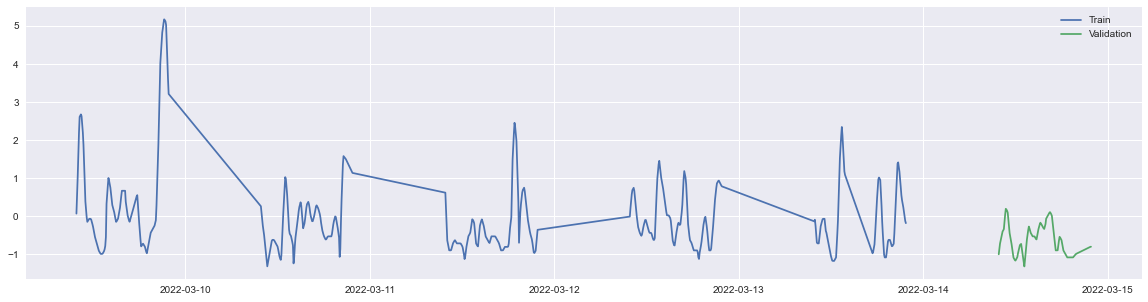

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(y_train_feat_scaled['glucose'], label='Train')
ax.plot(y_test_feat_scaled['glucose'], label='Validation')
ax.legend()

In [32]:
# extract unique ideal params from ideal params tuple
par = list(set([(_[1][0], _[1][2]) for _ in ideal_params]))
print(par)

[(1, 2), (2, 1), (4, 3), (3, 1), (1, 1), (2, 0), (3, 0), (2, 3), (1, 0)]


In [33]:
# too many features result in a non-pos estimate. trying out with selected features
s_features = ['glucose', 'sdnn', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'max_hr',
             'min_hr', 'hf', 'total_power', 'vlf']

y_train_feat_scaled = y_train_feat_scaled[s_features]
y_test_feat_scaled = y_test_feat_scaled[s_features]

In [34]:
@dask.delayed
def varma_harness(params, order):  
    model = VARMAX(endog=params, order=order)
    return model

@dask.delayed
def varma_fit_forecast(model, pred_len):
    res = model.fit()
    fcast = res.get_forecast(pred_len)
    return fcast

@dask.delayed
def eval_model(fcast, test):
    metrics = timeseries_evaluation_metrics_func(fcast, test)
    return metrics

def gridsearch_varma(train, test, possible_params, target='glucose'):
    r = []
    for combi in possible_params:
        mod = varma_harness(train, order=combi)
        fcast = varma_fit_forecast(mod, len(test))
        results = eval_model(test[target], fcast.predicted_mean[target])
        r.append((combi, results, fcast))
    return r

In [35]:
# %%time
# jobs = gridsearch_varma(y_train_feat_scaled,  y_test_feat_scaled, par) # 30 min runtime
# varma_scores = dask.compute(*jobs)

# run this cell to save on computation time for VARMA gridsearch
# with open('Pickle Files/varma_gridsearch_pkl', 'wb') as files:
#     pickle.dump(varma_scores, files)

In [36]:
# run this cell to save time for VARMA gridsearch (run above cell if first time)
with open('Pickle Files/varma_gridsearch_pkl', 'rb') as file:
    varma_scores = pickle.load(file)

In [37]:
pd.DataFrame(varma_scores) # p=1, q=0 has the best scores

,0,1,2
0,"(1, 2)","{'rmse': 0.7049563597983688, 'mae': 0.62106377...",<statsmodels.tsa.statespace.mlemodel.Predictio...
1,"(2, 1)","{'rmse': 0.7370093280959704, 'mae': 0.64969183...",<statsmodels.tsa.statespace.mlemodel.Predictio...
2,"(4, 3)","{'rmse': 0.7572038481474587, 'mae': 0.67331299...",<statsmodels.tsa.statespace.mlemodel.Predictio...
3,"(3, 1)","{'rmse': 0.7382913930981493, 'mae': 0.64738789...",<statsmodels.tsa.statespace.mlemodel.Predictio...
4,"(1, 1)","{'rmse': 0.7196911459737428, 'mae': 0.63476101...",<statsmodels.tsa.statespace.mlemodel.Predictio...
5,"(2, 0)","{'rmse': 0.7390615198901541, 'mae': 0.65207672...",<statsmodels.tsa.statespace.mlemodel.Predictio...
6,"(3, 0)","{'rmse': 0.7409833255883707, 'mae': 0.64994753...",<statsmodels.tsa.statespace.mlemodel.Predictio...
7,"(2, 3)","{'rmse': 0.7279701611142814, 'mae': 0.64011791...",<statsmodels.tsa.statespace.mlemodel.Predictio...
8,"(1, 0)","{'rmse': 0.7195034581582376, 'mae': 0.63476196...",<statsmodels.tsa.statespace.mlemodel.Predictio...


In [38]:
# extract p, q params with smallest RMSE
def get_best_var_params(scores, score_column=1, score="rmse"):
    lowest = 1
    best = None
    
    for i in scores:
        rmse = i[score_column][score]
        if rmse < lowest:
            lowest = rmse
            best = i
    return best
        
var_param = get_best_var_params(varma_scores) # best model as shown

In [39]:
conf_int = var_param[2].conf_int()
fcast = var_param[2].predicted_mean['glucose'].values
rmse = var_param[1]['rmse']

rmse for VARMA: 0.7049563597983688


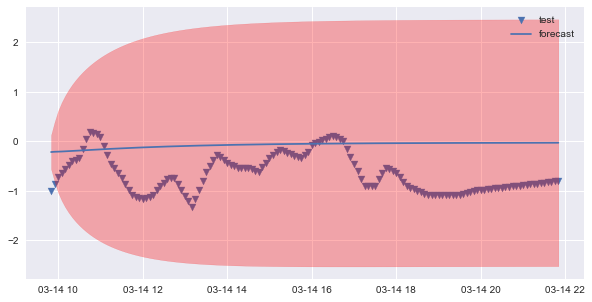

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test_feat_scaled.index, y_test_feat_scaled['glucose'], marker='v', label='test')
ax.plot(y_test_feat_scaled.index, fcast, label='forecast')
ax.fill_between(y_test_feat_scaled.index, \
                conf_int['lower glucose'], conf_int['upper glucose'], \
                color='red', alpha=0.3)
ax.legend()

print(f"rmse for VARMA: {rmse}")

# VAR(P)

Lag Order = 0
AIC :  -17.22096928140338
BIC :  -17.14489609929286
FPE :  3.3191591531148476e-08
HQIC:  -17.191606535178348 

Lag Order = 1
AIC :  -23.63785537487955
BIC :  -22.647833322708802
FPE :  5.4228817168509595e-11
HQIC:  -23.255701842200523 

Lag Order = 2
AIC :  -24.040560619044427
BIC :  -22.134608134737235
FPE :  3.626286605952971e-11
HQIC:  -23.304805938922872 

Lag Order = 3
AIC :  -24.24226718059465
BIC :  -21.41839559985509
FPE :  2.966124549969584e-11
HQIC:  -23.152098019664226 

Lag Order = 4
AIC :  -24.195276861981068
BIC :  -20.451490383065938
FPE :  3.113347155252112e-11
HQIC:  -22.749876899590564 

Lag Order = 5
AIC :  -24.167733568257667
BIC :  -19.502029216526054
FPE :  3.207941867786217e-11
HQIC:  -22.36628348146916 

Lag Order = 6
AIC :  -24.21464791460689
BIC :  -18.62501550684501
FPE :  3.0718626262154254e-11
HQIC:  -22.0563253630984 

Lag Order = 7
AIC :  -24.151047165265247
BIC :  -17.635469273785
FPE :  3.290000973986687e-11
HQIC:  -21.635026776137188 

La

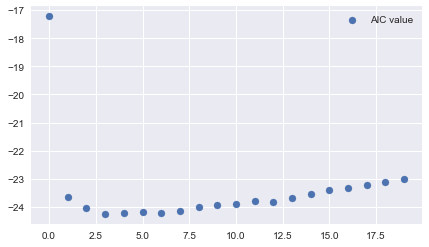

In [41]:
model = VAR(y_train_feat_scaled)

def plot_var_aic(model, iterables):
    arr = []
    for i in iterables:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
        arr.append(result.aic)
    return arr
    
aic = plot_var_aic(model, [i for i in range(20)])


fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter([i for i in range(20)], aic, label='AIC value')
ax.legend() # select AIC value of 3

In [42]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Apr, 2022
Time:                     13:06:53
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -21.4184
Nobs:                     720.000    HQIC:                  -23.1521
Log likelihood:          -3088.41    FPE:                2.96612e-11
AIC:                     -24.2423    Det(Omega_mle):     1.62566e-11
--------------------------------------------------------------------
Results for equation glucose
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.001374         0.005987           -0.229           0.818
L1.glucose             1.426981         0.036723           38.858           0.000
L1.sdnn               -0.003584         0.045032      

#### Check Serial Correlation of Residuals
- Durbin Watson's test for serial correlation

Results of this can vary from 0-4, closer to 2, no significant correlation, close to 0, positve serial correlation and closer to 4, negative serial correlation.

In [43]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(y_train_feat_scaled.columns, out):
    print((col), ':', round(val, 2))

glucose : 2.04
sdnn : 1.99
rmssd : 2.02
median_nni : 2.01
range_nni : 1.99
cvsd : 2.05
cvnni : 1.99
max_hr : 2.01
min_hr : 1.99
hf : 2.01
total_power : 1.99
vlf : 1.99


In [44]:
# Get the lag order
lag_order = model_fitted.k_ar
print(f"lag_order for VAR: {lag_order}")

lag_order for VAR: 3


In [45]:
# Input data for forecasting (e.g. last 3 time periods to forecast the first day)
forecast_input = y_train_feat_scaled.values[-lag_order:]
print(forecast_input)

[[-0.00701255 -0.31371812 -0.56211064  0.48324987 -0.15909693 -0.79339704
  -0.54168397 -0.35813584 -0.21677703 -0.64365081 -0.06257574  0.18532436]
 [-0.12704465  0.69167999 -0.03623485  0.34563184  0.18260996 -0.15014794
   0.54994541 -0.17799707 -0.21338678 -0.48056534  1.80097202  2.20896219]
 [-0.1864462  -0.33575056 -0.11568215  0.48074772 -0.61251568 -0.32506703
  -0.53136022 -0.39550121 -0.01487523 -0.44316936 -0.10506747  0.08304236]]


In [46]:
forecast = pd.DataFrame(model_fitted.forecast(y=forecast_input,
                                              steps=len(y_test_feat_scaled)),
                        index=y_test_feat_scaled.index, 
                        columns=y_test_feat_scaled.columns)

rmse for VARMA: 0.7049563597983688


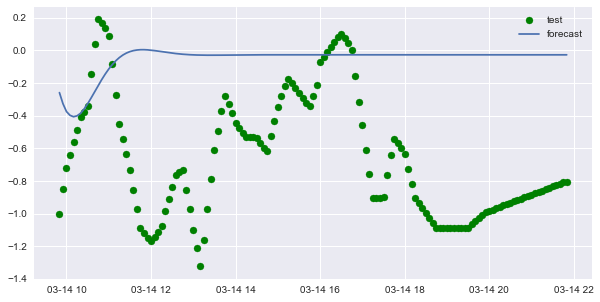

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y_test_feat_scaled.index, y_test_feat_scaled['glucose'], label='test',
           color='green')
ax.plot(forecast['glucose'], label='forecast')
ax.legend()

print(f"rmse for VARMA: {rmse}")

In [48]:
# save arima models

# pure arima

# sarimax

# varmax

# varP
